In [2]:
# see which are the main topics through the years. 
import os
import duckdb
import pyarrow.parquet as pq

def create_filtered_database_connection(parquet_directory: str, table_name: str, columns: list, min_score: int, min_post_length: int, start_date: int, end_date: int, max_expression_depth: int = 2500) -> duckdb.DuckDBPyConnection:
    """Create a filtered database connection and load only the necessary data."""
    # List all files in the directory
    all_files = os.listdir(parquet_directory)
    
    valid_files = []
    for file in all_files:
        file_path = f'{parquet_directory}/{file}'
        try:
            # Read the schema of the Parquet file
            parquet_file = pq.ParquetFile(file_path)
            schema = parquet_file.schema.to_arrow_schema()
            # Check if 'media' field exists and is of boolean type
            if schema.get_field_index('media') != -1 and schema.field('media').type == 'bool':
                valid_files.append(file)
            del parquet_file
        except Exception as e:
            print(f"Error reading schema of file {file}: {e}")
    
    # print(valid_files)
    files = [f'{parquet_directory}/{file}' for file in valid_files]
    con = duckdb.connect(database=':memory:')
    con.execute(f"SET max_expression_depth TO {max_expression_depth}")
    query_files = ', '.join(f"'{f}'" for f in files)
    
    # Define the schema with the specified columns
    columns_str = ', '.join(columns)
    
    # only load in the database what is necessary
    sql_query = f"""
    CREATE TABLE {table_name} AS 
    SELECT {columns_str} 
    FROM read_parquet([{query_files}], union_by_name=True)
    WHERE LENGTH(title) > {min_post_length}
      AND score > {min_score}
      AND selftext NOT LIKE '%[deleted]%'
      AND selftext NOT LIKE '%[removed]%'
      AND media = FALSE 
      AND {start_date} < created_utc 
      AND created_utc < {end_date}
    """
    
    try:
        con.execute(sql_query)
    except duckdb.ConversionException as e:
        print(f"Error creating table {table_name}: {e}")
        raise
    
    return con

In [4]:
# Database configuration and parameters for filtering
TABLE_NAME = 'submissions'
MIN_SCORE = 10
MIN_POST_LENGTH = 40
START_DATE= 1199179770 # 2008-01-01
END_DATE= 1672531200 # 2023-01-01

con = create_filtered_database_connection('../data/big_test', TABLE_NAME, ['id', 'title', 'selftext', 'created_utc', 'score', 'media'], MIN_SCORE, MIN_POST_LENGTH, START_DATE, END_DATE)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [35]:
# load ids from output/testing_pipeline/reddit_data.h5
import h5py
import numpy as np
import pandas as pd

with h5py.File('../output/testing_pipeline/reddit_data.h5', 'r') as f:
    ids = f['ids'][:]
    clusters = f['clusters'][:]

ids_list = ids.tolist()

clusters.resize(1, len(clusters))
ids.resize(1, len(ids))
decoded_ids = np.vectorize(lambda x: x.decode('utf-8'))(ids)

query = f"""
    SELECT id, created_utc
    FROM {TABLE_NAME}
    WHERE id IN ({','.join(['?']*len(ids_list))})
"""
df = con.execute(query, ids_list).fetchdf()

# # Step 4: Ensure that the retrieved elements are in the same order as the ids array
# df_sorted = pd.DataFrame(ids, columns=['id']).merge(df, on='id', how='left')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [47]:
concatenated = np.concatenate([clusters, decoded_ids], axis=0)
cluster_ids = pd.DataFrame(concatenated.T, columns=['cluster', 'id'])

df = df.merge(cluster_ids, on='id', how='left')
df

,id,created_utc,cluster
0,5n19ct,1484004675,-1
1,5n19cy,1484004676,-1
2,5n19dl,1484004681,-1
3,5n19dx,1484004683,34
4,5n19e4,1484004683,-1
...,...,...,...
9597645,7iakx7,1512689595,34
9597646,7iakxd,1512689596,-1
9597647,7iakxq,1512689597,44
9597648,7iaky8,1512689600,-1


/tmp/ipykernel_1175961/2884395155.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_clusters['month'] = df_top_clusters['created_utc'].dt.to_period('M')


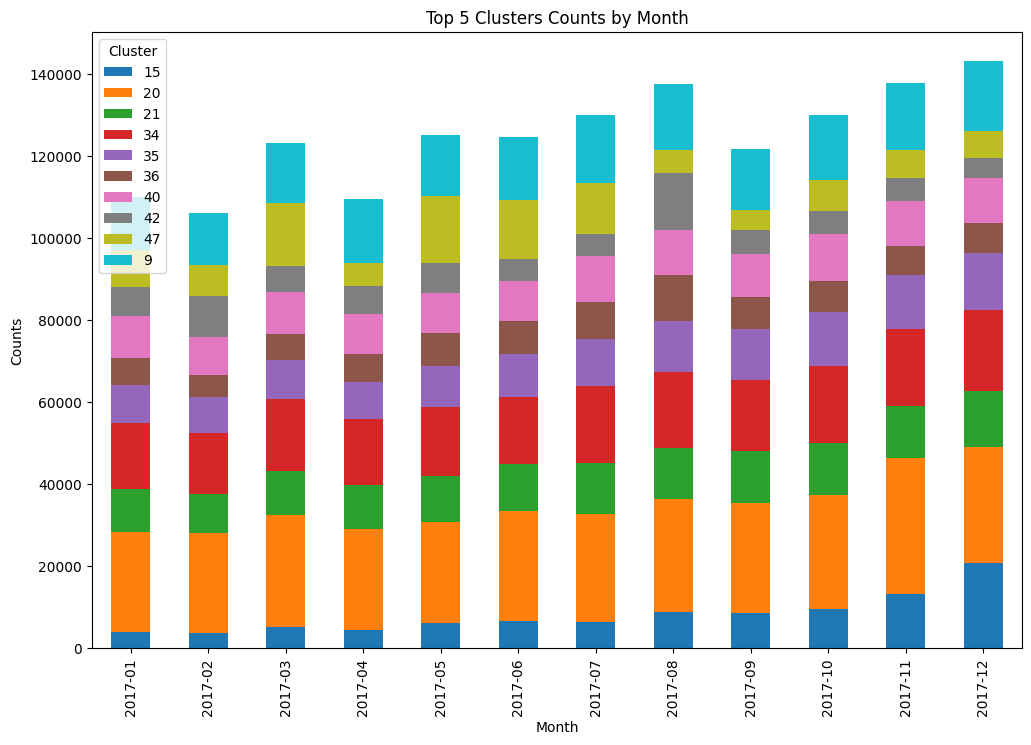

In [59]:
import pandas as pd
import matplotlib.pyplot as plt



df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')


# Filter out cluster -1
df_filtered = df[df['cluster'] != '-1']

# Find the top 5 clusters
top_clusters = df_filtered['cluster'].value_counts().head(10).index

# Filter the DataFrame to include only the top clusters
df_top_clusters = df_filtered[df_filtered['cluster'].isin(top_clusters)]

# The 'month' column needs to be added to df_top_clusters as well
df_top_clusters['month'] = df_top_clusters['created_utc'].dt.to_period('M')

# Group by month and cluster to count occurrences
cluster_counts_monthly = df_top_clusters.groupby(['month', 'cluster']).size().unstack(fill_value=0)

# Plotting
cluster_counts_monthly.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Top 5 Clusters Counts by Month')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.legend(title='Cluster')
plt.show()


In [2]:
import json

with open('../output/testing_different_subsets/coherence.json', 'r') as f:
    coherence = json.load(f)

overall_coherences = [(c['tf_idf_file'], c['overall_coherence'] )for c in coherence]

overall_coherences

[('output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  -3.70381145628456),
 ('output/testing_different_subsets/tf_idfs/tfids_0.1.json',
  -3.8060282763252786),
 ('output/testing_different_subsets/tf_idfs/tfids_0.2.json',
  -4.0540415265285015),
 ('output/testing_different_subsets/tf_idfs/tfids_0.4.json',
  -3.906504023168239),
 ('output/testing_different_subsets/tf_idfs/tfids_0.6.json',
  -4.076385702123595),
 ('output/testing_different_subsets/tf_idfs/tfids_0.8.json',
  -4.598891303504314),
 ('output/testing_different_subsets/tf_idfs/tfids_0.9.json',
  -3.929337699830228),
 ('output/testing_different_subsets/tf_idfs/tfids_1.0.json',
  -5.189240155933284),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -3.203857735160507),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -2.9927234818255286),
 ('output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  -2.991851793422402),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -3.

In [6]:
coherence

[{'tf_idf_file': 'output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  'date': '2024-07-31T17:03:11.445117',
  'coherence_per_topic': [-1.5125319639322738, -2.087031134657111],
  'overall_coherence': -1.7997815492946923},
 {'tf_idf_file': 'output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  'date': '2024-07-31T17:04:23.168598',
  'coherence_per_topic': [-3.0876578239318118,
   -2.8987230297940867,
   -2.653709093329577,
   -3.2295664179766543,
   -3.978337985764802,
   -2.9036543112888697,
   -3.1962992852206034,
   -1.8625490524758046,
   -1.9954127735436424,
   -2.1111641083541213,
   -2.017821749461971,
   -1.7063194572228064,
   -2.0315313447238816,
   -2.343034754095387,
   -2.778607468966867,
   -4.004042085571282,
   -3.999122008679625,
   -2.969671761371987,
   -3.4407072982474047,
   -3.229183117892682,
   -2.2244248133315323,
   -2.013915127369093,
   -3.217622749194497,
   -2.8786648558882146,
   -2.9632749836275574,
   -1.4756326139986695,
   -1.7088449496

In [1]:
import h5py



file_path = '../output/testing_pipeline/reddit_data.h5'
db_name = 'embeddings'

with h5py.File(file_path, "r") as file:
    dataset = file[db_name]
    data_block = dataset[:]  # +1 because max_idx is inclusive




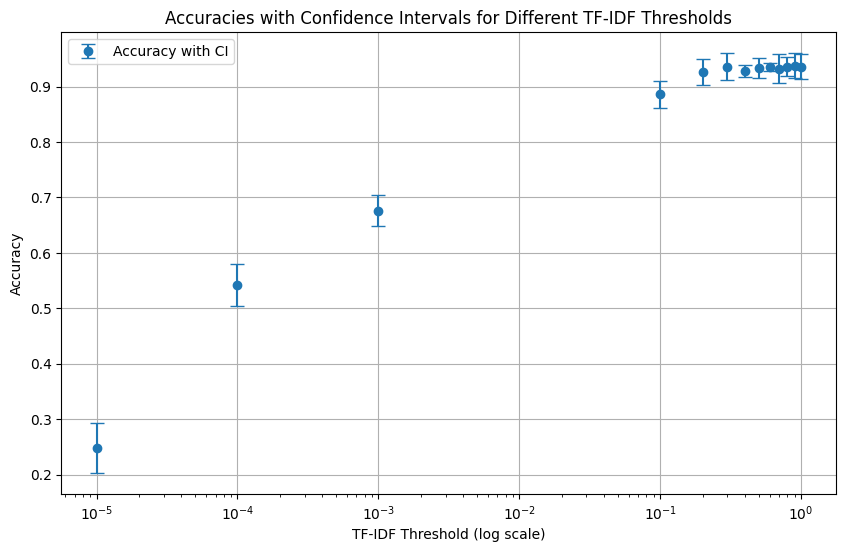

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data from user
data = [
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.00001.json",
        "accuracies": [
            0.28,
            0.29,
            0.19,
            0.18,
            0.3
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.0001.json",
        "accuracies": [
            0.55,
            0.59,
            0.47,
            0.52,
            0.58
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.001.json",
        "accuracies": [
            0.65,
            0.72,
            0.63,
            0.69,
            0.69
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.1.json",
        "accuracies": [
            0.87,
            0.93,
            0.85,
            0.88,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.2.json",
        "accuracies": [
            0.94,
            0.94,
            0.89,
            0.96,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.3.json",
        "accuracies": [
            0.95,
            0.92,
            0.98,
            0.9,
            0.93
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.4.json",
        "accuracies": [
            0.92,
            0.93,
            0.95,
            0.92,
            0.92
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.5.json",
        "accuracies": [
            0.9,
            0.96,
            0.93,
            0.93,
            0.95
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.6.json",
        "accuracies": [
            0.93,
            0.94,
            0.93,
            0.93,
            0.95
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.7.json",
        "accuracies": [
            0.92,
            0.96,
            0.94,
            0.88,
            0.96
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.8.json",
        "accuracies": [
            0.93,
            0.95,
            0.95,
            0.95,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.9.json",
        "accuracies": [
            0.92,
            0.96,
            0.97,
            0.94,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_1.0.json",
        "accuracies": [
            0.96,
            0.96,
            0.91,
            0.9,
            0.95
        ],
        "num_runs": 5
    }
]

# Extract x labels and accuracies
x_labels = [float(d["tf_idf_file"].split('_')[-1].split('.json')[0]) for d in data]
accuracies = [d["accuracies"] for d in data]

# Calculate means and confidence intervals
means = [np.mean(acc) for acc in accuracies]
std_devs = [np.std(acc) for acc in accuracies]
conf_intervals = [1.96 * (std / np.sqrt(len(acc))) for std, acc in zip(std_devs, accuracies)]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x_labels, means, yerr=conf_intervals, fmt='o', capsize=5, label='Accuracy with CI')
plt.xlabel('TF-IDF Threshold (log scale)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Accuracies with Confidence Intervals for Different TF-IDF Thresholds')
plt.grid(True)
plt.legend()
plt.show()


# Topic analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('../output/testing_different_subsets/final_dataframe.csv')
df = df[df.cluster != -1]   # drop noise cluster
print(df.head())

        id            subreddit  created_utc          author  \
4   2ixq8q  clickholeorbuzzfeed   1413024213  TheCyberGlitch   
7   2ixq9e              oneplus   1413024243          DakorZ   
8   2ixq9p                Metal   1413024253             ozh   
9   2ixq9s          environment   1413024257       anutensil   
10  2ixq9v      psychedelicrock   1413024259    FreudianMess   

                                                title  cluster  \
4   [65/34] 12 Feminist Cocktails To Make The Worl...       70   
7    I charged my phone over night and now it's dead.       65   
8   I need a metal song with a "stubborn bass". An...       30   
9   "Cloud Atlas" Author David Mitchell: "What a B...       69   
10  What are the worst live psych performances you...       30   

                                    topic_description  \
4   ['just', 'like', 'don', 'time', 'know', 'feel'...   
7   ['android', 'nexus', 'app', 'phone', 'iphone',...   
8   ['music', 'song', 'album', 'songs', 'like',

## Three different run to compare the topics found

This is done on the small subset of the data used above. We can see that most of the topics in the top 20 remain constant over time, altough the order and the naming might change slightly. This is due to the small stocasticity in HDBSCAN (cuml implementation) and in the naming of the topics with chatGPT. 

In [8]:
top_20_topics = df['topic'].value_counts().head(20)
top_20_topics

topic
Anime and Character Discussion       38234
Personal Reflections and Emotions    18392
Pets and Animals                     16231
Music and Streaming                  16189
Food and Recipes                     12738
Football Match Analysis               6782
Fashion and Clothing                  6688
Cryptocurrency and Trading            6461
Nature and Outdoor Activities         6342
Disaster Relief and Recovery          5407
Crime and Law Enforcement             5142
Keto Diet and Weight Loss             5078
Education and Career                  4979
Automobiles and Vehicles              4563
Superheroes and Comics                4524
Religion and Spirituality             4523
Mobile Technology and Apps            3644
Reddit and Online Communities         3596
Russia-Ukraine Conflict               3291
Beverages and Brewing                 3286
Name: count, dtype: int64

In [15]:
top_20_topics = df['topic'].value_counts().head(20)
top_20_topics

topic
Vegan Cooking and Recipes              25303
Personal Thoughts and Feelings         16986
Music and Streaming                    16678
Pets and Animals                       15435
Fan Art and Drawing                    11415
Fashion and Shopping                    9444
Football and Player Substitutions       7317
Cryptocurrency and Trading              6602
Holiday Celebrations                    6481
Adult Content                           6415
Religion and Spirituality               5268
Natural Disaster and Relief Efforts     5201
Diet and Nutrition                      5083
Crime and Law Enforcement               5052
Outdoor Activities and Nature           4796
Automobiles and Transportation          4735
Comic Books and Superheroes             4533
Education and Career Aspirations        4409
Reddit and Online Communities           4006
Ukrainian Conflict and War              3777
Name: count, dtype: int64

In [18]:
top_20_topics = df['topic'].value_counts().head(20)
top_20_topics

topic
Cooking and Recipes                         26113
Political Issues and Elections              20498
Emotions and Interpersonal Communication    17822
Music and Streaming                         15690
Pets and Animal Care                        11981
Adult Content and Sexual Themes              8373
Football Match Analysis                      7211
Cryptocurrency and Trading                   6415
Outdoor Activities and Nature                6141
Automotive and Vehicles                      5279
Natural Disasters and Relief Efforts         5210
Keto Diet and Weight Management              5164
Religion and Beliefs                         5123
Education and Career Aspirations             4688
Thrift Shopping and Hauls                    4228
Film and Television Discussion               4102
Reddit and Online Community Engagement       4012
Mobile Technology and Devices                3900
Conflict in Ukraine                          3821
Christmas and Holiday Celebrations          

In [20]:

df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['year_month'] = df['created_utc'].dt.to_period('M')

def plot_topic_over_time(df, topic):
    # Filter the data frame for the given topic
    topic_df = df[df['topic'] == topic]
    
    # Group by 'year_month' to count the number of posts per month for the given topic
    monthly_topic_counts = topic_df.groupby('year_month').size()
    print(monthly_topic_counts)
    # Plotting the results
    plt.figure(figsize=(14, 8))
    plt.plot(monthly_topic_counts.index.astype(str), monthly_topic_counts, label=topic, marker='o')
    
    plt.xlabel('Month')
    plt.ylabel('Number of Posts')
    plt.title(f'Number of Posts per Month for Topic: {topic}')
    plt.legend(title='Topic')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Some topic which should be correlated to life events

year_month
2014-10    1080
2017-08    1342
2018-12    1183
2020-08     486
2022-09     570
2022-10     777
2022-12     977
Freq: M, dtype: int64


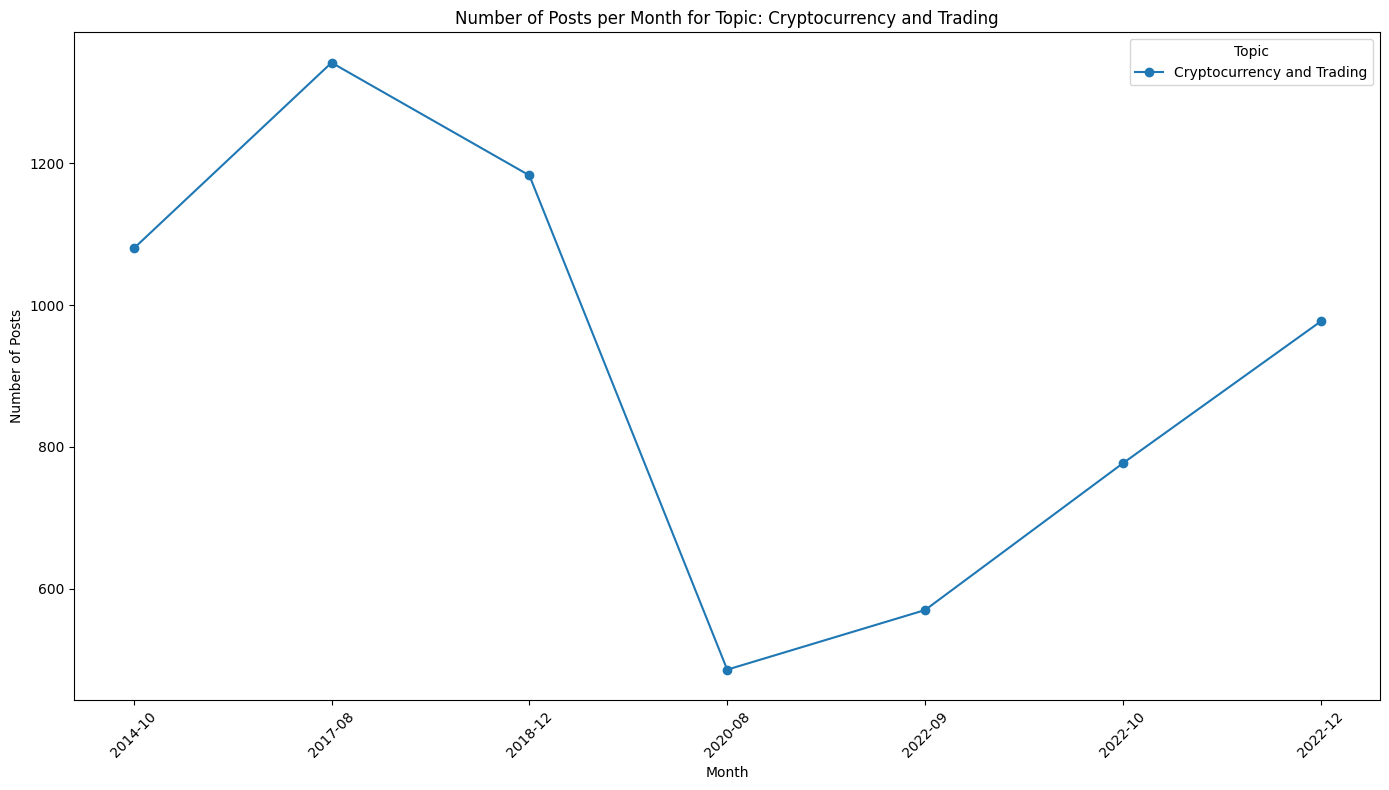

In [21]:
# Example usage:
topic = 'Cryptocurrency and Trading'  # Replace 'your_topic_here' with the topic you want to plot
plot_topic_over_time(df, topic)

year_month
2014-10     506
2017-08     259
2018-12     299
2020-08     215
2022-09    1000
2022-10     922
2022-12     620
Freq: M, dtype: int64


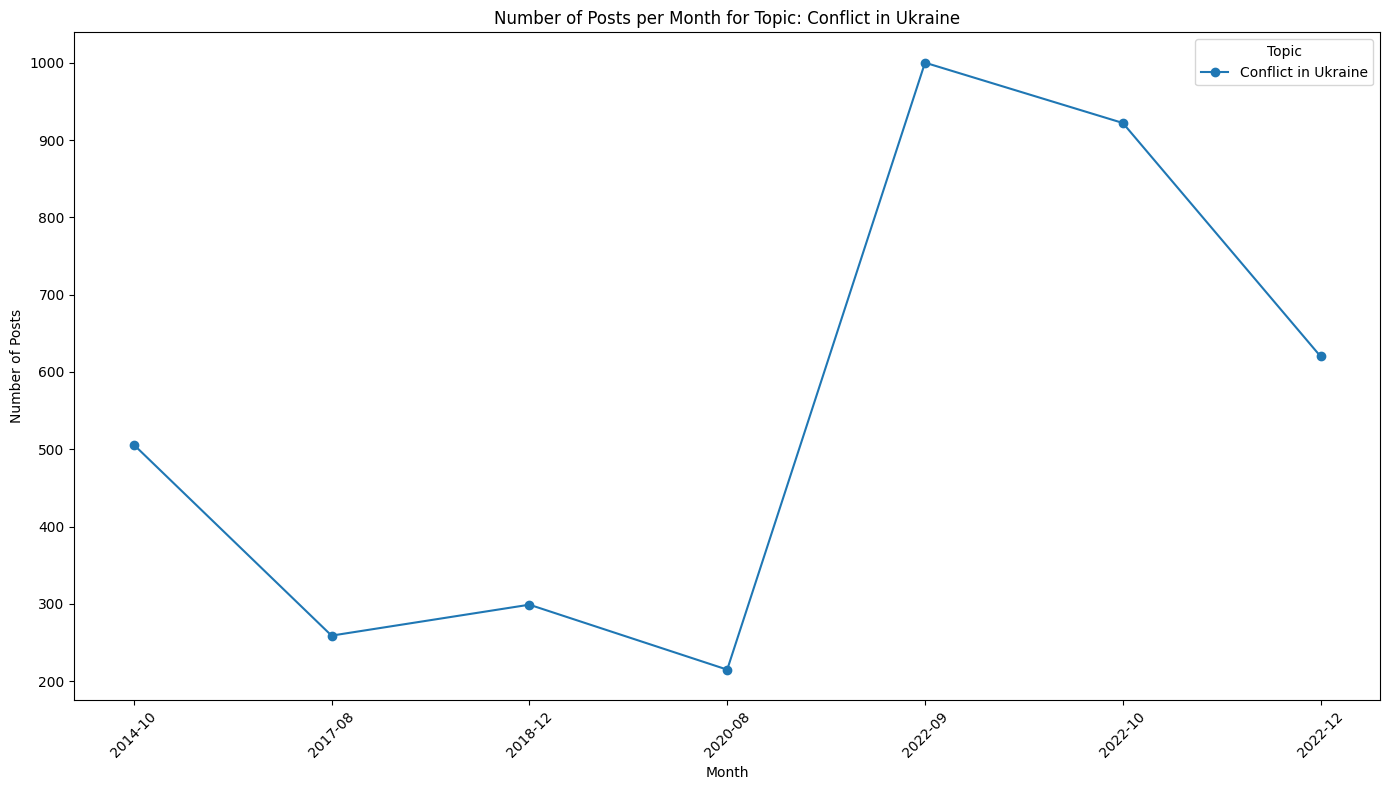

In [22]:
# Example usage:
topic = 'Conflict in Ukraine'  # Replace 'your_topic_here' with the topic you want to plot
plot_topic_over_time(df, topic)

# Number of topics in small subreddits

We plot the topics in these small subreddits and then print the topics which weren't the main one to inspect the title

In [27]:
def plot_topic_in_subreddit(df, subreddit_name):
    filtered_df = df[df['subreddit'] == subreddit_name]

    # Count the occurrences of each topic within that subreddit
    topic_counts = filtered_df['topic'].value_counts()

    # Plot the data
    plt.figure(figsize=(10, 6))
    topic_counts.plot(kind='barh', color='skyblue')
    plt.xlabel('Number of Posts')
    plt.ylabel('Topics')
    plt.title(f'Topics in Subreddit: {subreddit_name}')
    plt.gca().invert_yaxis()
    plt.show()

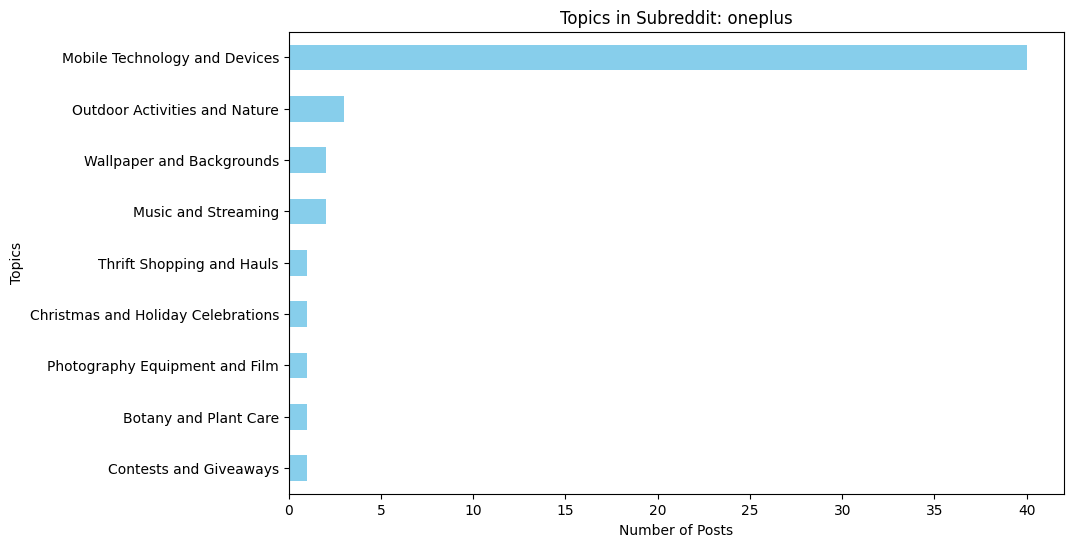

,title,topic
8007,Love the OPO in HDR. Not the New Jersey most people see.,Outdoor Activities and Nature
14309,The lock screen makes my live wallpaper look like a creepy forest,Wallpaper and Backgrounds
28453,taken with my Oneplus One right after heavy rain here in the Netherlands (Nijmegen),Outdoor Activities and Nature
68573,Apparently removing the safe headset volume limit might be against the law.. Who knew,Music and Streaming
106482,Ordered a OnePlus 5 yesterday. Just been through this sub...... should I be worried?,Thrift Shopping and Hauls
369106,Merry Christmas to me! [X-Post /r/Moto360],Christmas and Holiday Celebrations
371875,Moment is launching photography case lenses for the OnePlus 6 and OnePlus 6T,Photography Equipment and Film
505322,Thinking about the Silver Bullets? Consider this alternative.,Music and Streaming
572512,"Got a chance to use a OPO with the bamboo back, it felt very cheap. Very inferior to the sandstone back.",Botany and Plant Care
660779,"100k Subscribers Giveaway - 2x Bullets Wireless, 2x Explorer Backpack",Contests and Giveaways


In [37]:
plot_topic_in_subreddit(df, 'oneplus')

# Filtering the DataFrame based on the given conditions
filtered_df = df[(df['subreddit'] == 'oneplus') & (df['topic'] != 'Mobile Technology and Devices')]

# Ensuring that the entire title is printed
pd.set_option('display.max_colwidth', None)

# Selecting and displaying the required columns
filtered_df_result = filtered_df[['title', 'topic']]
filtered_df_result

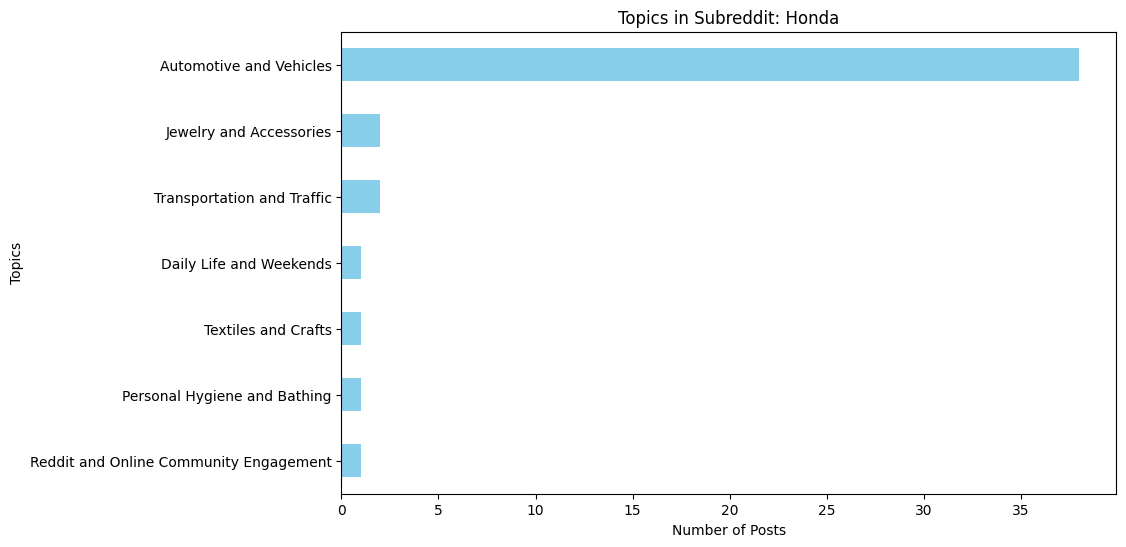

,title,topic
25593,Finally removed the pinstripes after a month and then detailed in and out. The feels (:,Jewelry and Accessories
34103,"If you find another hatch in the wild, do you park next to it too?",Transportation and Traffic
210519,How was everyone's weekend? I got to wash and wax my EK!,Daily Life and Weekends
210879,"I spent an hour sewing on a steering wheel cover, when I finished I realized I didn't pay attention to the seam placement ¯\_(ツ)_/¯",Textiles and Crafts
401658,After removing the b**** pin should the linkage just slide out? (b series linkage),Jewelry and Accessories
414773,Someone say Prelude day? Got a much needed bath today!,Personal Hygiene and Bathing
653095,It’s nice parking in a garage that lets in some natural light,Transportation and Traffic
736986,I've never seen this before. I have been missing out.,Reddit and Online Community Engagement


In [42]:

plot_topic_in_subreddit(df, 'Honda')

# Filtering the DataFrame based on the given conditions
filtered_df = df[(df['subreddit'] == 'Honda') & (df['topic'] != 'Automotive and Vehicles')]

# Ensuring that the entire title is printed
pd.set_option('display.max_colwidth', None)

# Selecting and displaying the required columns
filtered_df_result = filtered_df[['title', 'topic']]
filtered_df_result